# Scraping data from subreddit <a href='https://www.reddit.com/r/AskDocs/'>r/AskDocs</a> 🩺🥼

In [95]:
import praw
import pandas as pd
from datasets import Dataset
import yake
import math

In [96]:
reddit=praw.Reddit(user_agent=True,
                   client_secret='zS6cuhXCP0b1HCU0aSXl236vu9o9SA',client_id='OzzaZ-aY_0oo4TnMg0fnWA',username='EastLeft',password='randomaccnt278')

### These functions are used to check genuiness of a question and the replier. The keyword function is used to extract the keyword from the question
 1) Genuine Question: if it has help, medical or symptoms in the title
 2) Genuine Comment: only if it hasnt been deleted, removed or not been done by a bot

 We extract only the the **'top'** questions from the subreddit. I have refrained from scraping other filters like 'hot', 'controversial' etc. because they might have been yet replied by a professional. 10000 posts have been scraped. There is high possibility that the subreddit might not have 10000 posts in total.

In [97]:
def genuineQues(title):
    title=title.lower()
    if('help' in title or 'medical' in title or 'symptoms' in title):
        return 1
    return -1
def genuineComment(reply,role,author):
    
    if(reply=='[deleted]' or reply =='[removed]' or (author=='AutoModerator')):
        return -1
    return 1
def getkeyword(text):
    kw_extractor = yake.KeywordExtractor()
    language = "en"
    max_ngram_size =1
    deduplication_threshold = 0.9
    numOfKeywords = 1
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    return keywords[0]

### This code scraps the data taking the information from the thread. We limit the number of replies to 3.

1) Important data which is scraped from question is: Title, Post, Role of the Author(not verified)
2) Important data which is scraped from the comment is: Text, Role of the Commentator(should be a physician)

A thing to consider is the best answer could be at different level of 'depth' in a conversation. This approach only looks at the top 3 comments and not in the depth of each of the comment.

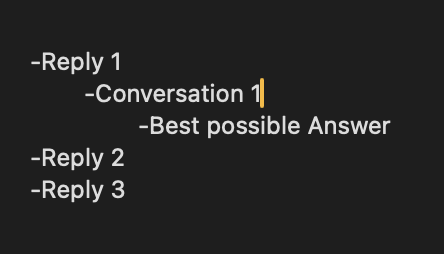

In [38]:
%%time
subreddit = reddit.subreddit('askdocs')
# Define lists to store data
data = []

# Scraping posts & Comments
for post in subreddit.top(limit= 10000): 
    if(genuineQues(post.title)==1):
        data.append({
            'Type': 'Post',
            'Post_id': post.id,
            'Title': post.title,
            'Author': post.author.name if post.author else 'Unknown',
            'Role':post.author_flair_text,
            'Timestamp': post.created_utc,
            'Text': post.selftext,
            'Score': post.score,
            'Total_comments': post.num_comments,
            'Post_URL': post.url
        })

    # Check if the post has comments
        if post.num_comments > 0:
            c=reddit.submission(url=post.url)
            c.comment_limit=3
            c.comments.replace_more(limit= 0)
            for comment in c.comments:
                data.append({
                'Type': 'Comment',
                'Post_id': post.id,
                'Title': post.title,
                'Author': comment.author.name if comment.author else 'Unknown',
                'Role':comment.author_flair_text,
                'Timestamp': pd.to_datetime(comment.created_utc, unit='s'),
                'Text': comment.body,
                'Score': comment.score,
                'Total_comments': 0,
                'Post_URL': None
                })



# Create pandas DataFrame for posts and comments
df = pd.DataFrame(data)
df.head(10)

CPU times: user 1.27 s, sys: 177 ms, total: 1.45 s
Wall time: 1min 30s


,Type,Post_id,Title,Author,Role,Timestamp,Text,Score,Total_comments,Post_URL
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,1594030661.0,"Dear users,\n\nRecently there have been nursin...",2773,1,https://www.reddit.com/r/AskDocs/comments/hm52...
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Layperson/not verified as healthcare professional,1681872922.0,I’m the person who posted yesterday because my...,2755,23,https://www.reddit.com/r/AskDocs/comments/12re...
2,Comment,12rebr3,Update on my husband with drooping mouth/other...,AutoModerator,None,2023-04-19 02:55:23,Thank you for your submission. **Please note t...,1,0,None
3,Comment,12rebr3,Update on my husband with drooping mouth/other...,NoBasil3262,Registered Nurse,2023-04-19 03:34:33,Thank you for the update!! Best wishes to both...,604,0,None
4,Comment,12rebr3,Update on my husband with drooping mouth/other...,Unknown,None,2023-04-19 02:56:41,[deleted],678,0,None
5,Post,i07g60,*SOLVED* After two years of mystery diagnosis ...,Unknown,None,1596052554.0,Original Post:\n\n [https://www.reddit.com/r/A...,2494,11,https://www.reddit.com/r/AskDocs/comments/i07g...
6,Comment,i07g60,*SOLVED* After two years of mystery diagnosis ...,Eastern_Concentrate8,Layperson/not verified as healthcare professio...,2020-07-29 20:06:30,So glad you found an answer and are on the way...,248,0,None
7,Comment,i07g60,*SOLVED* After two years of mystery diagnosis ...,jcarberry,Physician | Moderator,2020-07-29 21:26:42,"Thank you for updating, OP! Best of luck in yo...",1,0,None
8,Comment,i07g60,*SOLVED* After two years of mystery diagnosis ...,graye1999,This user has not yet been verified.,2020-07-29 20:15:35,That’s fascinating. I would have had a similar...,108,0,None
9,Post,e3nrbd,Need help - Harvard gave up - homeless,gooddiagnostician,Layperson/not verified as healthcare professio...,1575073307.0,Please take the time to read this. I am extre...,2134,236,https://www.reddit.com/r/AskDocs/comments/e3nr...


In [39]:
df.to_csv("askdocs.csv",index=False)

# Data preprocessing

In [98]:
import praw
import pandas as pd
from datasets import Dataset

In [99]:
df=pd.read_csv('askdocs.csv')
df

,Type,Post_id,Title,Author,Role,Timestamp,Text,Score,Total_comments,Post_URL
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,1594030661.0,"Dear users,\n\nRecently there have been nursin...",2773,1,https://www.reddit.com/r/AskDocs/comments/hm52...
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Layperson/not verified as healthcare professional,1681872922.0,I’m the person who posted yesterday because my...,2755,23,https://www.reddit.com/r/AskDocs/comments/12re...
2,Comment,12rebr3,Update on my husband with drooping mouth/other...,AutoModerator,NaN,2023-04-19 02:55:23,Thank you for your submission. **Please note t...,1,0,NaN
3,Comment,12rebr3,Update on my husband with drooping mouth/other...,NoBasil3262,Registered Nurse,2023-04-19 03:34:33,Thank you for the update!! Best wishes to both...,604,0,NaN
4,Comment,12rebr3,Update on my husband with drooping mouth/other...,Unknown,NaN,2023-04-19 02:56:41,[deleted],678,0,NaN
...,...,...,...,...,...,...,...,...,...,...
489,Comment,ychr4t,Bad burn wound- no health insurance. Please help!,kittencalledmeow,Physician,2022-10-24 18:55:50,This appears to be second degree bc of the bli...,687,0,NaN
490,Post,1ceap60,"Itchy anus, causing me to insert my finger in ...",throwitaway1231082,Layperson/not verified as healthcare professional,1714211022.0,"27M 190lbs 183cm. For sometime now, and I me...",373,130,https://www.reddit.com/r/AskDocs/comments/1cea...
491,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",AutoModerator,NaN,2024-04-27 09:43:43,Thank you for your submission. **Please note t...,1,0,NaN
492,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",Snownyann,Physician - Pathology,2024-04-27 11:14:50,"Hello, you have severe itching at the anus at ...",1152,0,NaN


In [100]:
df = df.drop('Timestamp',axis=1)
df = df.drop('Total_comments', axis=1)
df = df.drop('Post_URL', axis=1)
df

,Type,Post_id,Title,Author,Role,Text,Score
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users,\n\nRecently there have been nursin...",2773
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Layperson/not verified as healthcare professional,I’m the person who posted yesterday because my...,2755
2,Comment,12rebr3,Update on my husband with drooping mouth/other...,AutoModerator,NaN,Thank you for your submission. **Please note t...,1
3,Comment,12rebr3,Update on my husband with drooping mouth/other...,NoBasil3262,Registered Nurse,Thank you for the update!! Best wishes to both...,604
4,Comment,12rebr3,Update on my husband with drooping mouth/other...,Unknown,NaN,[deleted],678
...,...,...,...,...,...,...,...
489,Comment,ychr4t,Bad burn wound- no health insurance. Please help!,kittencalledmeow,Physician,This appears to be second degree bc of the bli...,687
490,Post,1ceap60,"Itchy anus, causing me to insert my finger in ...",throwitaway1231082,Layperson/not verified as healthcare professional,"27M 190lbs 183cm. For sometime now, and I me...",373
491,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",AutoModerator,NaN,Thank you for your submission. **Please note t...,1
492,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",Snownyann,Physician - Pathology,"Hello, you have severe itching at the anus at ...",1152


In [101]:
df.drop(df[df.Author =='AutoModerator'].index)
df.drop(df[df.Text =='[deleted]'].index)
df.drop(df[df.Text =='[removed]'].index)

,Type,Post_id,Title,Author,Role,Text,Score
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users,\n\nRecently there have been nursin...",2773
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Layperson/not verified as healthcare professional,I’m the person who posted yesterday because my...,2755
2,Comment,12rebr3,Update on my husband with drooping mouth/other...,AutoModerator,NaN,Thank you for your submission. **Please note t...,1
3,Comment,12rebr3,Update on my husband with drooping mouth/other...,NoBasil3262,Registered Nurse,Thank you for the update!! Best wishes to both...,604
4,Comment,12rebr3,Update on my husband with drooping mouth/other...,Unknown,NaN,[deleted],678
...,...,...,...,...,...,...,...
489,Comment,ychr4t,Bad burn wound- no health insurance. Please help!,kittencalledmeow,Physician,This appears to be second degree bc of the bli...,687
490,Post,1ceap60,"Itchy anus, causing me to insert my finger in ...",throwitaway1231082,Layperson/not verified as healthcare professional,"27M 190lbs 183cm. For sometime now, and I me...",373
491,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",AutoModerator,NaN,Thank you for your submission. **Please note t...,1
492,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",Snownyann,Physician - Pathology,"Hello, you have severe itching at the anus at ...",1152


In [102]:
df['Role'] = df['Role'].where(df['Role'] != 'Layperson/not verified as healthcare professional', 'Patient')
df['Role'] = df['Role'].where(df['Role'] != 'This user has not yet been verified.', 'Patient')

Now after dropping irrelevant columns and keeping important questions in the dataset, we start with tagging the comments with possible diseases. We remove the stopwords and prepare the corpus of the keywords from the "text". Only top 3 keywords are kept.

In [110]:
import spacy
from summa import keywords
# Load spaCy English model
key=[]
nlp = spacy.load("en_core_web_sm")
for i in range(len(df)):
    doc=nlp(df.iloc[i]['Text'])
    filtered_words = [token.text for token in doc if not token.is_stop]
    clean_text = ' '.join(filtered_words)
    df.loc[i,"Text"]=clean_text
    TR_keywords = keywords.keywords(clean_text, scores=True)
    TR_keywords=TR_keywords[0:2]
    for tup in TR_keywords:
        if(tup[0] not in key):
            key.append(tup[0])
print("Length of keyword corpus",len(key))
print("\n\nCorpus:",key)

Length of keyword corpus 491


Corpus: ['students', 'users', 'posted', 'thank', 'information', 'subreddit informal', 'update', 'post', 'posting', 'best', 'updating', 'similar', 'oral', 'feel like', 'feels', 'given', 'esophageal', 'content', 'view', 'syndrome', 'hospitals', 'hospital', 'bmi', 'nutrient', 'patient', 'patients', 'test', 'tested positive', 'dog', 'help', 'risk severe', 'wear', 'walk dog', 'brain', 'run', 'professional', 'halfway informed', 'wife', 'caused', 'cardiac causes', 'feeling', 'thoroughly', 'right', 'wifes', 'like', 'look', 'surgeons', 'history', 'know', 'road', 'aneurysm', 'time', 'motorcycles', 'scene motorcycle', 'friend', 'drinking friends', 'pregnant', 'gyne', 'pregnancy test', 'anxiety appointment', 'breath', 'breathe', 'going', 'answer', 'sorry grief feel', 'hope', 'ptsd symptoms', 'fiancee picking', 'neurologist', 'neurologists', 'pain', 'dangerous', 'knows', 'painful', 'rape', 'decide', 'recent', 'recently', 'applied', 'blood', 'needed', 'phone', 'doctor'

In [104]:
df

,Type,Post_id,Title,Author,Role,Text,Score
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users , \n\n Recently nursing schools swi...",2773
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Patient,"person posted yesterday husband ( 42 male , 32...",2755
2,Comment,12rebr3,Update on my husband with drooping mouth/other...,AutoModerator,NaN,Thank submission . * * note response constitut...,1
3,Comment,12rebr3,Update on my husband with drooping mouth/other...,NoBasil3262,Registered Nurse,Thank update ! ! Best wishes - healing comfort !,604
4,Comment,12rebr3,Update on my husband with drooping mouth/other...,Unknown,NaN,[ deleted ],678
...,...,...,...,...,...,...,...
489,Comment,ychr4t,Bad burn wound- no health insurance. Please help!,kittencalledmeow,Physician,appears second degree bc blistering . Burns te...,687
490,Post,1ceap60,"Itchy anus, causing me to insert my finger in ...",throwitaway1231082,Patient,"27 M 190lbs 183 cm . , mean year , anus itc...",373
491,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",AutoModerator,NaN,Thank submission . * * note response constitut...,1
492,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",Snownyann,Physician - Pathology,"Hello , severe itching anus night ? thing came...",1152


# Main challenge I felt is how do I tag the question with a disease???
Solution: Prepare a list of of diseases from some medical database. I found a github repo having a text file which has all the diseases.
https://github.com/CodeSante/medical-wordlist/blob/main/en/disease.en.<br><br>
I then filtered the keywords from the Text corpus and diseases. I ended up having roughly 153 keywords

In [190]:
def word_appears_in_files(word_list, file_paths):
    imp=[]
        # Iterate through each file path
    for file_path in file_paths:
            # Open the file in read mode
        with open(file_path, 'r') as file:
                # Read the contents of the file
            file_contents = file.read()
                
                # Check if any word from the list appears in the file
            for word in word_list:
                if word in file_contents:
                    imp.append(word)  # Return True if word is found in file, along with file path
        # If none of the words are found in any file
    return imp

# Example usage
file_paths = [ "disease.en.txt"]  # Replace with the paths to your files

# Check if any word from the list appears in one of the files
l = word_appears_in_files(key, file_paths)
print("Keywords in corpus and disease text file",l)
print("\n\nLength of keywords: ",len(l))

Keywords in corpus and disease text file ['post', 'best', 'oral', 'esophageal', 'syndrome', 'test', 'dog', 'wear', 'brain', 'run', 'caused', 'right', 'like', 'know', 'road', 'aneurysm', 'time', 'gyne', 'hope', 'pain', 'painful', 'rape', 'blood', 'food', 'gastroparesis', 'note', 'vaccine', 'symptoms', 'bet', 'edit', 'diarrhea', 'pediatric', 'bleeding', 'fibroid', 'hour', 'inflammation', 'case', 'non', 'new', 'disorder', 'er', 'x', 'bit', 'think', 'eyes', 'eye', 'attention', 'posts', 'age', 'bladder', 'difficult', 'vomiting', 'rectum', 'ct', 'link', 'op', 'brain tumor', 'family', 'survival', 'diabetes', 'life', 'heart', 'chest', 'morphine', 'mom', 'seizures', 'period', 'functional', 'good', 'psychosis', 'dr', 'sexual', 'disease', 'puberty', 'hard', 'weight', 'baby', 'hands', 'mask', 'city', 'issues', 'chronic', 'drug', 'activate', 'dementia', 'contact', 'came', 'rheumatoid', 'pt', 'home', 'stoma', 'bowel', 'bf', 'seizure', 'attack', 'attacks', 'obstruction', 'cancer', 'infection', 'liver

In [114]:
i=0
while(i<len(df)-1):
    if(df['Type'][i]=='Post'):
        j=i+1
        while(j<len(df) and df['Type'][j]=='Comment'):
            reply=df['Text'][j]
            role=df['Role'][j]
            author=df['Author'][j]
            if((genuineComment(reply,role,author))==-1):
                df.drop(j)
            j+=1
    i+=1
df

,Type,Post_id,Title,Author,Role,Text,Score
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users , \n\n Recently nursing schools...",2773
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Patient,"person posted yesterday husband ( 42 male , 32...",2755
2,Comment,12rebr3,Update on my husband with drooping mouth/other...,AutoModerator,NaN,Thank submission . * * note response constitut...,1
3,Comment,12rebr3,Update on my husband with drooping mouth/other...,NoBasil3262,Registered Nurse,Thank update ! ! Best wishes - healing comfort !,604
4,Comment,12rebr3,Update on my husband with drooping mouth/other...,Unknown,NaN,[ deleted ],678
...,...,...,...,...,...,...,...
489,Comment,ychr4t,Bad burn wound- no health insurance. Please help!,kittencalledmeow,Physician,appears second degree bc blistering . Burns te...,687
490,Post,1ceap60,"Itchy anus, causing me to insert my finger in ...",throwitaway1231082,Patient,"27 M 190lbs 183 cm . , mean year , anus...",373
491,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",AutoModerator,NaN,Thank submission . * * note response constitut...,1
492,Comment,1ceap60,"Itchy anus, causing me to insert my finger in ...",Snownyann,Physician - Pathology,"Hello , severe itching anus night ? thing came...",1152


In [115]:
i=0
df = df.drop(df[df.Type == 'Comment'].index)
i+=1
df

,Type,Post_id,Title,Author,Role,Text,Score
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users , \n\n Recently nursing schools...",2773
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Patient,"person posted yesterday husband ( 42 male , 32...",2755
5,Post,i07g60,*SOLVED* After two years of mystery diagnosis ...,Unknown,NaN,Original Post : \n\n [ https://www.reddit...,2494
9,Post,e3nrbd,Need help - Harvard gave up - homeless,gooddiagnostician,Layperson/not verified as healthcare professio...,time read . extremely sick sure going su...,2134
13,Post,ru1vrj,Am I at imminent risk of death? I’m scared. Pl...,Throwaway579z,Patient,"18F , BMI 12.2 , located \n\n medications ...",1802
...,...,...,...,...,...,...,...
476,Post,mxe8oh,"I have a fingernail stuck in my nose, please help",dumbnosegirl,Layperson/not verified as healthcare professio...,"15F , 5'2 "" , 120 lbs , white , medicati...",395
480,Post,d2bluk,[26F] I have no acess to healthcare and need h...,idontwannadiehelp,Layperson/not verified as healthcare professio...,"Warning : English language , bad grammar ahead...",387
484,Post,en76pf,Being told by surgeon and other medical profes...,hemorrhoidbegone22,Layperson/not verified as healthcare professio...,Hello . \n\n stats : \n\n 32 M \n\n ...,382
487,Post,ychr4t,Bad burn wound- no health insurance. Please help!,dreiscray,Patient,Hello thanks taking time help . ( 28F 5’0 125 ...,385


# We just keep the posts and delete the comments from the dataset creating a final csv

In [ ]:
df.to_csv('final.csv',index=False)
df

,Type,Post_id,Title,Author,Role,Text,Score
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users , \n\n Recently nursing schools swi...",2773
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Patient,"person posted yesterday husband ( 42 male , 32...",2755
5,Post,i07g60,*SOLVED* After two years of mystery diagnosis ...,Unknown,NaN,Original Post : \n\n [ https://www.reddit.com...,2494
9,Post,e3nrbd,Need help - Harvard gave up - homeless,gooddiagnostician,Layperson/not verified as healthcare professio...,time read . extremely sick sure going surviv...,2134
13,Post,ru1vrj,Am I at imminent risk of death? I’m scared. Pl...,Throwaway579z,Patient,"18F , BMI 12.2 , located \n\n medications \n\n...",1802
...,...,...,...,...,...,...,...
476,Post,mxe8oh,"I have a fingernail stuck in my nose, please help",dumbnosegirl,Layperson/not verified as healthcare professio...,"15F , 5'2 "" , 120 lbs , white , medications ...",395
480,Post,d2bluk,[26F] I have no acess to healthcare and need h...,idontwannadiehelp,Layperson/not verified as healthcare professio...,"Warning : English language , bad grammar ahead...",387
484,Post,en76pf,Being told by surgeon and other medical profes...,hemorrhoidbegone22,Layperson/not verified as healthcare professio...,Hello . \n\n stats : \n\n 32 M \n\n 6'0 \n\n 2...,382
487,Post,ychr4t,Bad burn wound- no health insurance. Please help!,dreiscray,Patient,Hello thanks taking time help . ( 28F 5’0 125 ...,385


### Tagging the text: Using Zero Shot to label the data

In [118]:
from transformers import pipeline
import pandas as pd
newcsv=pd.read_csv('final.csv')
newcsv

,Type,Post_id,Title,Author,Role,Text,Score
0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users , \n\n Recently nursing schools ...",2773
1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Patient,"person posted yesterday husband ( 42 male , 32...",2755
2,Post,i07g60,*SOLVED* After two years of mystery diagnosis ...,Unknown,NaN,Original Post : \n\n [ https://www.reddit....,2494
3,Post,e3nrbd,Need help - Harvard gave up - homeless,gooddiagnostician,Layperson/not verified as healthcare professio...,time read . extremely sick sure going sur...,2134
4,Post,ru1vrj,Am I at imminent risk of death? I’m scared. Pl...,Throwaway579z,Patient,"18F , BMI 12.2 , located \n\n medications \...",1802
...,...,...,...,...,...,...,...
136,Post,mxe8oh,"I have a fingernail stuck in my nose, please help",dumbnosegirl,Layperson/not verified as healthcare professio...,"15F , 5'2 "" , 120 lbs , white , medicatio...",395
137,Post,d2bluk,[26F] I have no acess to healthcare and need h...,idontwannadiehelp,Layperson/not verified as healthcare professio...,"Warning : English language , bad grammar ahead...",387
138,Post,en76pf,Being told by surgeon and other medical profes...,hemorrhoidbegone22,Layperson/not verified as healthcare professio...,Hello . \n\n stats : \n\n 32 M \n\n 6...,382
139,Post,ychr4t,Bad burn wound- no health insurance. Please help!,dreiscray,Patient,Hello thanks taking time help . ( 28F 5’0 125 ...,385


In [162]:

zs_class = pipeline("zero-shot-classification",model="facebook/bart-large-mnli")
i=0
while(i<len(df)-1):
    text=""
    text=newcsv['Title'][i]+' '+newcsv['Text'][i]
    lc  = zs_class(text, l)
    print(lc['labels'][0])
    newcsv['Label']=lc['labels'][0]
    i+=1

associated
symptoms
associated
possible
contact
family
edit
think
associated


KeyboardInterrupt: 

In [120]:
labelY=[]
with open("labelsoutput.txt") as file:
  for item in file:
    labelY.append(item[:len(item)-1])
labelY.sort()
print(len(labelY))

141


In [123]:

newcsv['Label'] = labelY
newcsv.to_csv("finalfinal.csv")

newcsv=pd.read_csv('finalfinal.csv')
newcsv

,Unnamed: 0,Type,Post_id,Title,Author,Role,Text,Score,Label
0,0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users , \n\n Recently nursing schools ...",2773,anxiety
1,1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Patient,"person posted yesterday husband ( 42 male , 32...",2755,arm
2,2,Post,i07g60,*SOLVED* After two years of mystery diagnosis ...,Unknown,NaN,Original Post : \n\n [ https://www.reddit....,2494,associate
3,3,Post,e3nrbd,Need help - Harvard gave up - homeless,gooddiagnostician,Layperson/not verified as healthcare professio...,time read . extremely sick sure going sur...,2134,associated
4,4,Post,ru1vrj,Am I at imminent risk of death? I’m scared. Pl...,Throwaway579z,Patient,"18F , BMI 12.2 , located \n\n medications \...",1802,associated
...,...,...,...,...,...,...,...,...,...
136,136,Post,mxe8oh,"I have a fingernail stuck in my nose, please help",dumbnosegirl,Layperson/not verified as healthcare professio...,"15F , 5'2 "" , 120 lbs , white , medicatio...",395,think
137,137,Post,d2bluk,[26F] I have no acess to healthcare and need h...,idontwannadiehelp,Layperson/not verified as healthcare professio...,"Warning : English language , bad grammar ahead...",387,time
138,138,Post,en76pf,Being told by surgeon and other medical profes...,hemorrhoidbegone22,Layperson/not verified as healthcare professio...,Hello . \n\n stats : \n\n 32 M \n\n 6...,382,ulcerative
139,139,Post,ychr4t,Bad burn wound- no health insurance. Please help!,dreiscray,Patient,Hello thanks taking time help . ( 28F 5’0 125 ...,385,ventriculomegaly


## So we started by scraping 10,000 posts and are left with 141 posts in the dataset.

<hr>
<hr>

# Fine Tuning

In [124]:
import pandas as pd
from datasets import Dataset
from datasets import load_dataset

In [125]:
dataf=pd.read_csv("finalfinal.csv")
df = dataf.rename(columns={'Text': 'text', 'Label': 'label'})
target=df['label'].unique().tolist()
target.sort()
d_map={}
for i, target_var in enumerate(target):
    d_map[i]=target_var

In [126]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(dataf['Label'])
df

,Unnamed: 0,Type,Post_id,Title,Author,Role,text,Score,label
0,0,Post,hm525p,Announcement: only medical students will be ve...,murpahurp,Physician | Moderator | Top Contributor,"Dear users , \n\n Recently nursing schools ...",2773,0
1,1,Post,12rebr3,Update on my husband with drooping mouth/other...,imeanyoucouldsure,Patient,"person posted yesterday husband ( 42 male , 32...",2755,1
2,2,Post,i07g60,*SOLVED* After two years of mystery diagnosis ...,Unknown,NaN,Original Post : \n\n [ https://www.reddit....,2494,2
3,3,Post,e3nrbd,Need help - Harvard gave up - homeless,gooddiagnostician,Layperson/not verified as healthcare professio...,time read . extremely sick sure going sur...,2134,3
4,4,Post,ru1vrj,Am I at imminent risk of death? I’m scared. Pl...,Throwaway579z,Patient,"18F , BMI 12.2 , located \n\n medications \...",1802,3
...,...,...,...,...,...,...,...,...,...
136,136,Post,mxe8oh,"I have a fingernail stuck in my nose, please help",dumbnosegirl,Layperson/not verified as healthcare professio...,"15F , 5'2 "" , 120 lbs , white , medicatio...",395,34
137,137,Post,d2bluk,[26F] I have no acess to healthcare and need h...,idontwannadiehelp,Layperson/not verified as healthcare professio...,"Warning : English language , bad grammar ahead...",387,35
138,138,Post,en76pf,Being told by surgeon and other medical profes...,hemorrhoidbegone22,Layperson/not verified as healthcare professio...,Hello . \n\n stats : \n\n 32 M \n\n 6...,382,36
139,139,Post,ychr4t,Bad burn wound- no health insurance. Please help!,dreiscray,Patient,Hello thanks taking time help . ( 28F 5’0 125 ...,385,37


In [48]:
from sklearn.model_selection import train_test_split

train,val=train_test_split(df)

#train_texts,test_texts,train_labels,test_labels=train_test_split(train_texts,train_labels,test_size=0.01,random_state=0)


In [49]:
train_ds=Dataset.from_pandas(train)
val_ds=Dataset.from_pandas(val)

In [50]:
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
import tensorflow as tf
# Loading the dataset to train our model
model_checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)

def encode(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_ds.map(encode, batched=True)
tokenized_val_dataset = val_ds.map(encode, batched=True)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [33]:
from datasets import load_metric
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=0.1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=1e-5,
    eval_steps=100
)
trainer_model=DistilBertForSequenceClassification.from_pretrained(model_checkpoint,num_labels=39)

# Train the model
trainer = Trainer(
    model=trainer_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()
result = trainer.evaluate()
print(result)

/var/folders/ch/81y0l1c54gq99fjztzggxt6m0000gn/T/ipykernel_935/1423195040.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-bas

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 11.799607276916504, 'eval_accuracy': 0.027777777777777776, 'eval_runtime': 0.3598, 'eval_samples_per_second': 100.046, 'eval_steps_per_second': 25.011, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 3.191551685333252, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3054, 'eval_samples_per_second': 117.89, 'eval_steps_per_second': 29.473, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 2.9451210498809814, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3037, 'eval_samples_per_second': 118.525, 'eval_steps_per_second': 29.631, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 2.8785791397094727, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.2962, 'eval_samples_per_second': 121.541, 'eval_steps_per_second': 30.385, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 2.8766627311706543, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3093, 'eval_samples_per_second': 116.397, 'eval_steps_per_second': 29.099, 'epoch': 5.0}
{'train_runtime': 17.136, 'train_samples_per_second': 30.637, 'train_steps_per_second': 4.085, 'train_loss': 22.946608189174107, 'epoch': 5.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 2.8766627311706543, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.2582, 'eval_samples_per_second': 139.406, 'eval_steps_per_second': 34.852, 'epoch': 5.0}


## Save the model

In [65]:
saved='saved_models'
trainer_model.save_pretrained(saved)
tokenizer.save_pretrained(saved)

('saved_models/tokenizer_config.json',
 'saved_models/special_tokens_map.json',
 'saved_models/vocab.txt',
 'saved_models/added_tokens.json')

# Load model

In [191]:
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
import tensorflow as tf
import time
saved='saved_models'
model_ft=DistilBertForSequenceClassification.from_pretrained(saved)
tokenizer_ft=DistilBertTokenizer.from_pretrained(saved)
text="Stomach ulcer and vomiting blood since last 3 days"
start=time.time()
pred=tokenizer_ft.encode(text,truncation=True,padding=True, return_tensors='pt')
output=tf.argmax(pred,axis=1).numpy()[0]
end=time.time()
print(d_map[output])
print((end-start)*1000)

cancer
1.8260478973388672


In [187]:
text="My elbow is scraped"
start=time.time()
pred=tokenizer_ft.encode(text,truncation=True,padding=True, return_tensors='pt')
output=tf.argmax(pred,axis=1).numpy()[0]
end=time.time()
print(d_map[output])
print((end-start)*1000)

bleeding
1.2428760528564453


In [186]:
text="I am at loss of breath after climbing. I am 20 year old boy with 150 kg weight. "
start=time.time()
pred=tokenizer_ft.encode(text,truncation=True,padding=True, return_tensors='pt')
output=tf.argmax(pred,axis=1).numpy()[0]
end=time.time()
print(d_map[output])
print((end-start)*1000)

diagnosed
0.8342266082763672


# LORA Fine Tuning

In [168]:
import os
import torch
from transformers import (AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline, logging)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [169]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=1, lora_alpha=1, lora_dropout=0.1
)

In [170]:
from transformers import BertForSequenceClassification
model_checkpoint="distilbert-base-uncased"
loramodel = BertForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=39
)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

In [171]:
from peft import get_peft_model
lmodel = get_peft_model(loramodel, lora_config)
lora_tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)


In [172]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [173]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [174]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",
                                 num_train_epochs=5,)

In [175]:
trainer = Trainer(
    model=lmodel,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [176]:
trainer.train()

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 3.7031850814819336, 'eval_accuracy': 0.0, 'eval_runtime': 0.4743, 'eval_samples_per_second': 75.898, 'eval_steps_per_second': 10.541, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 3.6290194988250732, 'eval_accuracy': 0.0, 'eval_runtime': 0.4652, 'eval_samples_per_second': 77.382, 'eval_steps_per_second': 10.748, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 3.5747909545898438, 'eval_accuracy': 0.0, 'eval_runtime': 0.4661, 'eval_samples_per_second': 77.244, 'eval_steps_per_second': 10.728, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 3.5416746139526367, 'eval_accuracy': 0.0, 'eval_runtime': 0.4662, 'eval_samples_per_second': 77.219, 'eval_steps_per_second': 10.725, 'epoch': 4.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 3.5296881198883057, 'eval_accuracy': 0.0, 'eval_runtime': 0.4657, 'eval_samples_per_second': 77.301, 'eval_steps_per_second': 10.736, 'epoch': 5.0}
{'train_runtime': 19.8095, 'train_samples_per_second': 26.502, 'train_steps_per_second': 3.534, 'train_loss': 3.6217132568359376, 'epoch': 5.0}


TrainOutput(global_step=70, training_loss=3.6217132568359376, metrics={'train_runtime': 19.8095, 'train_samples_per_second': 26.502, 'train_steps_per_second': 3.534, 'train_loss': 3.6217132568359376, 'epoch': 5.0})

In [177]:
saved='saved'
trainer_model.save_pretrained(saved)
lora_tokenizer.save_pretrained(saved)

('saved/tokenizer_config.json',
 'saved/special_tokens_map.json',
 'saved/vocab.txt',
 'saved/added_tokens.json')

In [183]:
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
import tensorflow as tf
saved='saved'
model_ft=DistilBertForSequenceClassification.from_pretrained(saved)
tokenizer_ft=DistilBertTokenizer.from_pretrained(saved)
text="Stomach ulcer and vomiting since last 3 days"
start=time.time()
pred=tokenizer_ft.encode(text,truncation=True,padding=True, return_tensors='pt')
output=tf.argmax(pred,axis=1).numpy()[0]
end=time.time()
print(d_map[output])
print((end-start)*1000)

cancer
0.5192756652832031


In [184]:
text="My elbow is scraped"
start=time.time()
pred=tokenizer_ft.encode(text,truncation=True,padding=True, return_tensors='pt')
output=tf.argmax(pred,axis=1).numpy()[0]
end=time.time()
print(d_map[output])
print((end-start)*1000)

bleeding
1.1141300201416016


In [185]:
text="I am at loss of breath after climbing. I am 20 year old boy with 150 kg weight. "
start=time.time()
pred=tokenizer_ft.encode(text,truncation=True,padding=True, return_tensors='pt')
output=tf.argmax(pred,axis=1).numpy()[0]
end=time.time()
print(d_map[output])
print((end-start)*1000)

diagnosed
1.2769699096679688


# Benchmark testing 